# LSTM的Pytorch API使用以及手动实现LSTM Forward函数
- [LSTM的理解｜博客](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- 这里实现了LSTM和LSTMP，其中LSTMP就是对隐藏状态和输出的维度进行了压缩，可以降低计算量和参数量
- 这里只实现了单向、单层的LSTM，双向或者双层的情况和RNN是类似的
- LSTM Forward公式：
    - ![CleanShot 2024-08-01 at 17.21.01@2x.png](<attachment:CleanShot 2024-08-01 at 17.21.01@2x.png>)
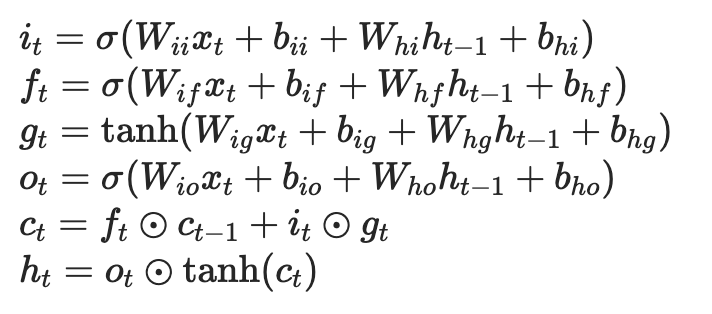

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

bs, T, i_size, h_size = 2, 3, 4, 5  # 批大小, 输入序列长度, 输入特征长度, 输出特征长度
proj_size = 3 # 一般proj_size比h_size小，进行压缩
input = torch.randn(bs, T, i_size)  # 随机初始化一个特征序列
h0 = torch.zeros(bs, h_size)  # 初始隐含状态
c0 = torch.zeros(bs, h_size)  # 初始值 不会参与训练 初始细胞状态

In [36]:
# LSTM的Pytorch官方API调用
lstm_layer = nn.LSTM(i_size, h_size, batch_first = True)
output, (h_final, c_final) = lstm_layer(input, (h0.unsqueeze(0), c0.unsqueeze(0)))
print(output)

for k, v in lstm_layer.named_parameters():
    print(k, v.shape)
# 这里注意一下，虽然LSTM分为cell门、遗忘门、输入门、输出门等等，但是在内部实现的时候是会把他们的参数concat起来(在第0维, 5*4）一起进行快速矩阵运算

tensor([[[ 0.0714,  0.0557, -0.2320, -0.0338, -0.0112],
         [ 0.1384, -0.0942, -0.1996,  0.0266, -0.1163],
         [-0.0767, -0.0132, -0.2811, -0.0877, -0.0204]],

        [[-0.1511,  0.1231,  0.1563, -0.1965,  0.1836],
         [-0.1608,  0.2854, -0.0331, -0.1999,  0.1192],
         [-0.1810,  0.2089, -0.1762, -0.0931,  0.0287]]],
       grad_fn=<TransposeBackward0>)
weight_ih_l0 torch.Size([20, 4])
weight_hh_l0 torch.Size([20, 5])
bias_ih_l0 torch.Size([20])
bias_hh_l0 torch.Size([20])


In [37]:
# LSTM的动手实现
def lstm_forward(input, initial_states: tuple, w_ih, w_hh, b_ih, b_hh):
    h0, c0 = initial_states # 初始隐含状态和初始细胞状态
    bs, T, i_size = input.shape
    h_size = w_ih.shape[0] // 4
    # 注意这里不能是 w_hh.shape[1] 这样的话如果没有proj就还好  有proj的时候这个值就等于proj_size了  而不是h_size
    prev_h = h0
    prev_c = c0
    
    output_size = h_size
    output = torch.zeros(bs, T, output_size)
    
    for t in range(T):
        x = input[:, t, :] # [bs, i_size]
        w_times_x = x @ w_ih.T # [bs, h_size*4]
        w_times_h = prev_h @ w_hh.T # [bs, h_size*4]

        # 分别计算输入门i  遗忘门f  cell门g  输出门o
        i_t = torch.sigmoid(w_times_x[:, :h_size] + w_times_h[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])
        f_t = torch.sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h[:, h_size:2*h_size] + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = torch.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h[:, 2*h_size:3*h_size] + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = torch.sigmoid(w_times_x[:, 3*h_size:] + w_times_h[:, 3*h_size:] + b_ih[3*h_size:] + b_hh[3*h_size:])

        prev_c = f_t * prev_c + i_t * g_t
        prev_h = o_t * torch.tanh(prev_c)

        output[:, t, :] = prev_h

    return output, (prev_h, prev_c)

In [38]:
# 验证
output_custom, (h_final_custom, c_final_custom) = lstm_forward(input, (h0, c0), lstm_layer.weight_ih_l0, lstm_layer.weight_hh_l0, \
                                                               lstm_layer.bias_ih_l0, lstm_layer.bias_hh_l0)

In [39]:
print("PyTorch API output:")
print(output)
print(h_final) 
print(c_final)
print("\nlstm_forward function output:")
print(output_custom) 
print(h_final_custom)
print(c_final_custom)


PyTorch API output:
tensor([[[ 0.0714,  0.0557, -0.2320, -0.0338, -0.0112],
         [ 0.1384, -0.0942, -0.1996,  0.0266, -0.1163],
         [-0.0767, -0.0132, -0.2811, -0.0877, -0.0204]],

        [[-0.1511,  0.1231,  0.1563, -0.1965,  0.1836],
         [-0.1608,  0.2854, -0.0331, -0.1999,  0.1192],
         [-0.1810,  0.2089, -0.1762, -0.0931,  0.0287]]],
       grad_fn=<TransposeBackward0>)
tensor([[[-0.0767, -0.0132, -0.2811, -0.0877, -0.0204],
         [-0.1810,  0.2089, -0.1762, -0.0931,  0.0287]]],
       grad_fn=<StackBackward0>)
tensor([[[-0.2929, -0.0275, -0.4630, -0.2035, -0.0659],
         [-0.4735,  0.4182, -0.3645, -0.1707,  0.0601]]],
       grad_fn=<StackBackward0>)

lstm_forward function output:
tensor([[[ 0.0714,  0.0557, -0.2320, -0.0338, -0.0112],
         [ 0.1384, -0.0942, -0.1996,  0.0266, -0.1163],
         [-0.0767, -0.0132, -0.2811, -0.0877, -0.0204]],

        [[-0.1511,  0.1231,  0.1563, -0.1965,  0.1836],
         [-0.1608,  0.2854, -0.0331, -0.1999,  0.119

In [40]:
# 接下来使用proj_size参数
# 使用了proj_size的官方实现
lstm_layer_proj = nn.LSTM(i_size, h_size, batch_first = True, proj_size=proj_size)
# 当使用proj的时候，会对h维度进行压缩，所以相应的输入需要改变
h0_proj = torch.randn(bs, proj_size)
output_proj, (h_final_proj, c_final_proj) = lstm_layer_proj(input, (h0_proj.unsqueeze(0), c0.unsqueeze(0)))
print(output_proj)

for k, v in lstm_layer_proj.named_parameters():
    print(k, v.shape) 
# 可以看到多了一个参数weight_hr_l0, 这个参数就是用来对隐藏层特征维度进行压缩的

tensor([[[-0.0128, -0.0518, -0.1154],
         [ 0.0257, -0.0022, -0.1165],
         [ 0.0881, -0.0497, -0.0371]],

        [[-0.0928,  0.0179,  0.0172],
         [-0.0733, -0.0163, -0.0497],
         [ 0.0461, -0.0044, -0.0177]]], grad_fn=<TransposeBackward0>)
weight_ih_l0 torch.Size([20, 4])
weight_hh_l0 torch.Size([20, 3])
bias_ih_l0 torch.Size([20])
bias_hh_l0 torch.Size([20])
weight_hr_l0 torch.Size([3, 5])


In [41]:
# 使用了proj_size的手动实现
def lstm_forward_proj(input, initial_states: tuple, w_ih, w_hh, b_ih, b_hh, w_hr=None):
    h0, c0 = initial_states # 初始隐含状态和初始细胞状态
    bs, T, i_size = input.shape
    h_size = w_ih.shape[0] // 4
    # 注意这里不能是 w_hh.shape[1] 这样的话如果没有proj就还好  有proj的时候这个值就等于proj_size了  而不是h_size

    prev_h = h0
    prev_c = c0

    # 有了proj以后, ouput的大小会发生改变
    if w_hr is not None:
        p_size = w_hr.shape[0]
        output_size = p_size
    else:
        output_size = h_size
    output = torch.zeros(bs, T, output_size)
    
    for t in range(T):
        x = input[:, t, :] # [bs, i_size]
        w_times_x = x @ w_ih.T # [bs, h_size*4]
        w_times_h = prev_h @ w_hh.T # [bs, h_size*4]

        # 分别计算输入门i  遗忘门f  cell门g  输出门o
        i_t = torch.sigmoid(w_times_x[:, :h_size] + w_times_h[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])
        f_t = torch.sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h[:, h_size:2*h_size] + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = torch.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h[:, 2*h_size:3*h_size] + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = torch.sigmoid(w_times_x[:, 3*h_size:] + w_times_h[:, 3*h_size:] + b_ih[3*h_size:] + b_hh[3*h_size:])

        prev_c = f_t * prev_c + i_t * g_t
        prev_h = o_t * torch.tanh(prev_c) # [bs, h_size]
        
        if w_hr is not None:
            prev_h = prev_h @ w_hr.T # [bs, p_size]

        output[:, t, :] = prev_h # [bs, p_size]

    return output, (prev_h, prev_c)

In [42]:
# 验证
output_custom_proj, (h_final_custom_proj, c_final_custom_proj) = lstm_forward_proj(input, (h0_proj, c0), lstm_layer_proj.weight_ih_l0, lstm_layer_proj.weight_hh_l0, \
                                                               lstm_layer_proj.bias_ih_l0, lstm_layer_proj.bias_hh_l0, lstm_layer_proj.weight_hr_l0)

In [43]:
print("PyTorch API output:")
print(output_proj)
print(h_final_proj) 
print(c_final_proj)
print("\nlstm_forward function output:")
print(output_custom_proj) 
print(h_final_custom_proj)
print(c_final_custom_proj)

PyTorch API output:
tensor([[[-0.0128, -0.0518, -0.1154],
         [ 0.0257, -0.0022, -0.1165],
         [ 0.0881, -0.0497, -0.0371]],

        [[-0.0928,  0.0179,  0.0172],
         [-0.0733, -0.0163, -0.0497],
         [ 0.0461, -0.0044, -0.0177]]], grad_fn=<TransposeBackward0>)
tensor([[[ 0.0881, -0.0497, -0.0371],
         [ 0.0461, -0.0044, -0.0177]]], grad_fn=<StackBackward0>)
tensor([[[-0.3565, -0.0455,  0.1897,  0.0373,  0.1310],
         [-0.0269, -0.0201,  0.5269, -0.1776,  0.0187]]],
       grad_fn=<StackBackward0>)

lstm_forward function output:
tensor([[[-0.0128, -0.0518, -0.1154],
         [ 0.0257, -0.0022, -0.1165],
         [ 0.0881, -0.0497, -0.0371]],

        [[-0.0928,  0.0179,  0.0172],
         [-0.0733, -0.0163, -0.0497],
         [ 0.0461, -0.0044, -0.0177]]], grad_fn=<CopySlices>)
tensor([[ 0.0881, -0.0497, -0.0371],
        [ 0.0461, -0.0044, -0.0177]], grad_fn=<MmBackward0>)
tensor([[-0.3565, -0.0455,  0.1897,  0.0373,  0.1310],
        [-0.0269, -0.0201,  0